# Codigo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:

@jit(nopython=True) 
def create_mash(L):
    N = L**2
    lsing = np.random.rand(N)
    for i in range(N):
        lsing[i] = 1 if lsing[i] > 0.5 else -1
        
    return lsing

In [3]:
@jit(nopython=True)
def vizinhos(L):
    N = L ** 2
    #Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0: viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1): viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0): viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L: viz[k,3] = k+N-L
    return viz

In [4]:
@jit(nopython=True)
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [5]:
@jit(nopython=True)
def calc_energy(L, neighbors, S):
    N = L ** 2
    E = 0
    for i in range(N):
        h = S[neighbors[i, 0]] + S[neighbors[i, 1]]
        E -= S[i] * h 
    return E

# Metropolis

In [6]:
@jit(nopython=True)
def metropolis(T, S, neighbors, expoentes):
    for i in range (S.size):
        h = S[neighbors[i, 0]] + S[neighbors[i, 1]] + S[neighbors[i, 2]] + S[neighbors[i, 3]]
        r = np.random.rand()

        if r <= expoentes[int(h*S[i]*0.5 + 2)]:
            S[i] *= -1
    
    return S, neighbors
    

# Monte Carlo

In [7]:
@jit(nopython=True)
def Monte_Carlos(L, T, Steps : int):
    S = create_mash(L)
    neighbors = vizinhos(L)

    Energys = []
    Energys.append(calc_energy(L, neighbors, S))

    Magnetizacao = []
    Magnetizacao.append(S.sum())

    expoentes = expos(1/T)
    
    for i in range(Steps):
        S, neighbors =  metropolis(T, S, neighbors, expoentes)
        Energys.append(calc_energy(L, neighbors, S))
        Magnetizacao.append(S.sum())
    
    return Energys, Magnetizacao

In [25]:
def statistic_err(Arr):
    return np.sqrt(((Arr - Arr.mean())**2).sum()/(Arr.size*(Arr.size - 1)))


In [19]:
def Monte_Carlos_calc_and_print(L: int, T: int, N_passos, N_passos_ignorados, tamanho_do_bloco, n_bins):
    np.random.seed(0)
    energia, magnetizacao = Monte_Carlos(L, T, N_passos)
    energy = energia[N_passos_ignorados:]
    mags = magnetizacao[N_passos_ignorados:]

    n_blocos = (N_passos - N_passos_ignorados) // tamanho_do_bloco

    calor_esp = np.empty(n_blocos)
    sucep_mag = np.empty(n_blocos)
    spin_energy = np.empty(n_blocos)
    spin_mag = np.empty(n_blocos)

    for i in range(n_blocos):
        E = np.asarray((energy[i*tamanho_do_bloco:(i+1)*tamanho_do_bloco]))
        beta = 1 / T
        calor_esp[i] = (beta**2/tamanho_do_bloco) * ((E**2).mean() - (E.mean())**2)

        M = np.asarray((mags[i*tamanho_do_bloco:(i+1)*tamanho_do_bloco]))
        sucep_mag[i] = (beta/tamanho_do_bloco) *((M**2).mean() - (M.mean())**2)

        spin_energy[i] = E.mean() / L**2
        spin_mag[i] = M.mean() / L**2
    
    returnMatrix = np.zeros((4, 2))
    returnMatrix[:, 0] = np.array([calor_esp.mean(), sucep_mag.mean(), spin_energy.mean(), spin_mag.mean()])
    returnMatrix[:, 1] = np.array([statistic_err(calor_esp), statistic_err(sucep_mag), statistic_err(spin_energy), statistic_err(spin_mag)])

    return returnMatrix
    # fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
    # fig.suptitle("L = {}, e T = {}".format(L, T))

    # ax1.hist(calor_esp, label="valor Médio {:.2}".format(calor_esp.mean()), bins=n_bins)
    # ax1.set_ylabel("Calor")
    # ax1.legend()

    # ax2.hist(sucep_mag, label="valor Médio {:.2}".format(sucep_mag.mean()), bins=n_bins)
    # ax2.set_ylabel("magnetica")
    # ax2.legend()

    # ax3.hist(spin_energy, label="valor Médio {:.2}".format(spin_energy.mean()), bins=n_bins)
    # ax3.set_ylabel("Energia")
    # ax3.legend()

    # ax4.hist(spin_mag, label="valor Médio {:.2}".format(spin_mag.mean()), bins=n_bins)
    # ax4.set_ylabel("Magnetização Spin")
    # ax4.legend()

    # plt.show()

# Execucao

## Variando a temperatura

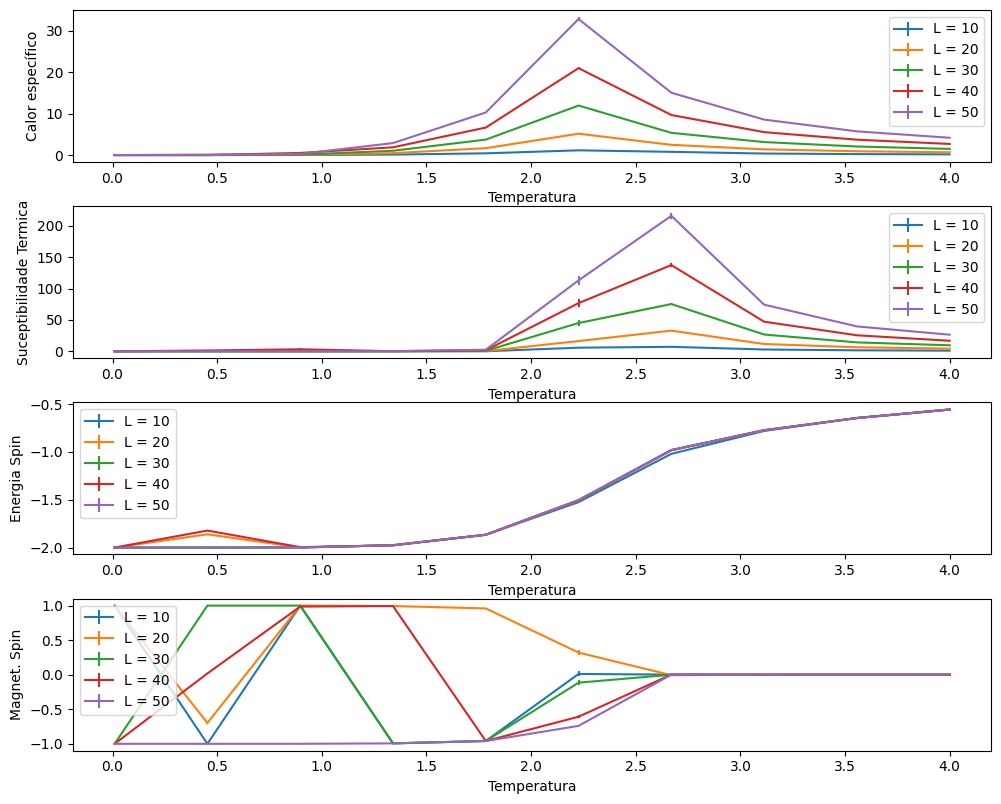

In [49]:


temperaturas = np.linspace(0.01, 4, 10)
tamanhos = [10, 20, 30, 40, 50]
calor_especifico = np.zeros((10, 2))
sucep_termic = np.zeros((10, 2))
energ_spin = np.zeros((10, 2))
magnet_spin = np.zeros((10, 2))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
fig.tight_layout()
for tamanho in tamanhos:
    i = 0
    for temperatura in temperaturas:
        info_termodinamica = Monte_Carlos_calc_and_print(tamanho, temperatura, 42000, 2001, 100, 60)
        calor_especifico[i, :] = info_termodinamica[0, :]
        sucep_termic[i, :] = info_termodinamica[1, :]
        energ_spin[i, :] = info_termodinamica[2, :]
        magnet_spin[i, :] = info_termodinamica[3, :]
        i += 1

    ax1.errorbar(temperaturas, calor_especifico[:, 0], yerr=calor_especifico[:, 1], label= f"L = {tamanho}")

    ax2.errorbar(temperaturas, sucep_termic[:, 0], yerr=sucep_termic[:, 1], label= f"L = {tamanho}")

    ax3.errorbar(temperaturas, energ_spin[:, 0], yerr=energ_spin[:, 1], label= f"L = {tamanho}")

    ax4.errorbar(temperaturas, magnet_spin[:, 0], yerr=magnet_spin[:, 1], label= f"L = {tamanho}")

ax1.set_ylabel('Calor específico')
ax2.set_ylabel('Suceptibilidade Termica')
ax3.set_ylabel('Energia Spin')
ax4.set_ylabel('Magnet. Spin')

ax1.set_xlabel('Temperatura')
ax2.set_xlabel('Temperatura')
ax3.set_xlabel('Temperatura')
ax4.set_xlabel('Temperatura')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

## Variando o tamanho


In [ ]:


for tamanho in tamanhos:
    Monte_Carlos_calc_and_print(int(tamanho), 1.5, 42000, 2001, 100, 60)